In [ ]:
import tsai
from tsai.all import *
import pandas as pd
import scipy
from sklearn.metrics import roc_auc_score, classification_report

from winkie import ts_prep

# Load and perpare data

In [ ]:
df = pd.read_hdf("merged_20210405.h5")

In [ ]:
df

bodyparts       head                              beak                         \
coords             x           y likelihood          x           y likelihood   
0         -86.161646   97.779806   0.999928 -61.602803  131.826909   0.999998   
1         -40.700035  125.159155   0.999942  -5.608340  144.849624   0.999999   
2         -90.698115   98.489233   0.999948 -64.815185  129.157615   0.999998   
3         -40.132962  128.538278   0.999944  -4.321594  144.734508   0.999999   
4         -42.783107  128.111861   0.999951  -6.318496  145.690291   0.999998   
...              ...         ...        ...        ...         ...        ...   
71921      -2.129188  147.939512   0.999963  -9.277470  167.856846   0.999954   
71922      -2.303441  153.270775   0.999944  -9.049379  172.894855   0.999961   
71923      -2.379451  153.530188   0.999944  -8.854504  173.617776   0.999965   
71924      -2.193165  152.864748   0.999931  -9.422234  172.449841   0.999969   
71925      -1.680429  151.695969   0.999850  -9.856747  172.201424   0.999993   

bodyparts  left_neck                        right_neck  ...       body  \
coords             x           y likelihood          x  ... likelihood   
0          35.205749   96.340594   0.998214 -35.205749  ...   0.999973   
1          13.182534  111.782684   0.999142 -13.182534  ...   0.999991   
2          33.668881   92.965449   0.998667 -33.668881  ...   0.999992   
3          13.424191  110.014341   0.999882 -13.424191  ...   0.999994   
4          13.480103  111.136276   0.999615 -13.480103  ...   0.999994   
...              ...         ...        ...        ...  ...        ...   
71921      38.227153  102.794973   1.000000 -38.227153  ...   0.999098   
71922      38.051577  107.351284   1.000000 -38.051577  ...   0.999878   
71923      38.065932  108.093086   1.000000 -38.065932  ...   0.999742   
71924      37.927681  107.823677   1.000000 -37.927681  ...   0.999631   
71925      37.478860  107.811497   1.000000 -37.478860  ...   0.999820   

bodyparts       tail                          middle_neck              \
coords             x           y likelihood             x           y   
0         -18.172716 -123.964518   0.999990 -1.488908e-15   73.699789   
1         -64.061815 -107.355783   0.999979 -1.070421e-14   85.328797   
2         -17.916153 -125.546694   0.999974 -5.861929e-15   68.759229   
3         -68.656699 -107.001174   0.999980 -1.967693e-14   82.523133   
4         -66.032609 -106.862755   0.999981  5.089889e-15   83.065330   
...              ...         ...        ...           ...         ...   
71921      11.714473 -129.575324   0.999897 -6.397545e-15  105.431831   
71922      14.127471 -124.719843   0.999798 -2.644396e-14  109.374953   
71923      15.019737 -124.774182   0.999883 -2.235504e-14  110.528096   
71924      14.818930 -125.447630   0.999919 -6.257710e-15  109.624685   
71925      16.172833 -125.226869   0.999924 -3.629767e-14  109.557994   

bodyparts rotation_angle  \
coords                     
0            -116.335718   
1             -93.299874   
2            -116.112460   
3             -90.772105   
4             -91.951232   
...                  ...   
71921        -102.807669   
71922        -103.288100   
71923        -103.183562   
71924        -103.568746   
71925        -103.619683   

bodyparts                                                              file_name  \
coords                                                                             
0          233_1000ms_gopro_cut_day1DLC_resnet50_goprovrJul24shuffle1_1030000.h5   
1          233_1000ms_gopro_cut_day1DLC_resnet50_goprovrJul24shuffle1_1030000.h5   
2          233_1000ms_gopro_cut_day1DLC_resnet50_goprovrJul24shuffle1_1030000.h5   
3          233_1000ms_gopro_cut_day1DLC_resnet50_goprovrJul24shuffle1_1030000.h5   
4          233_1000ms_gopro_cut_day1DLC_resnet50_goprovrJul24shuffle1_1030000.h5   
...                                                                          ...

<AxesSubplot:title={'center':'Training frames by behavior'}>

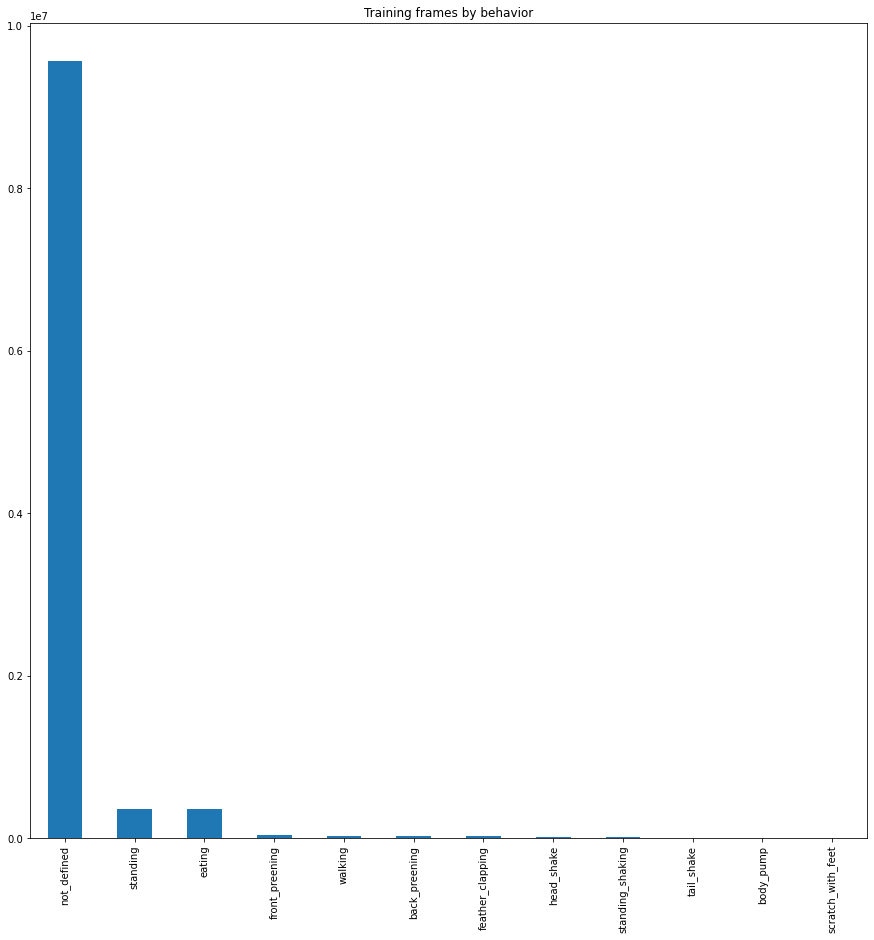

In [ ]:
df.behavior.value_counts().plot(kind='bar', figsize=(15,15), title='Training frames by behavior')

In [ ]:
df.loc[(df['behavior'] == "back_preening") | (df['behavior'] == "front_preening"), 'behavior'] = "preening"
df.loc[(df['behavior'] == "standing_shaking") | (df['behavior'] == "scratch_with_feet"), 'behavior'] = "standing"
df.loc[(df['behavior'] == "body_pump") | (df['behavior'] == "feather_clapping"), 'behavior'] = "fluffing"

<AxesSubplot:title={'center':'Training frames by behavior'}>

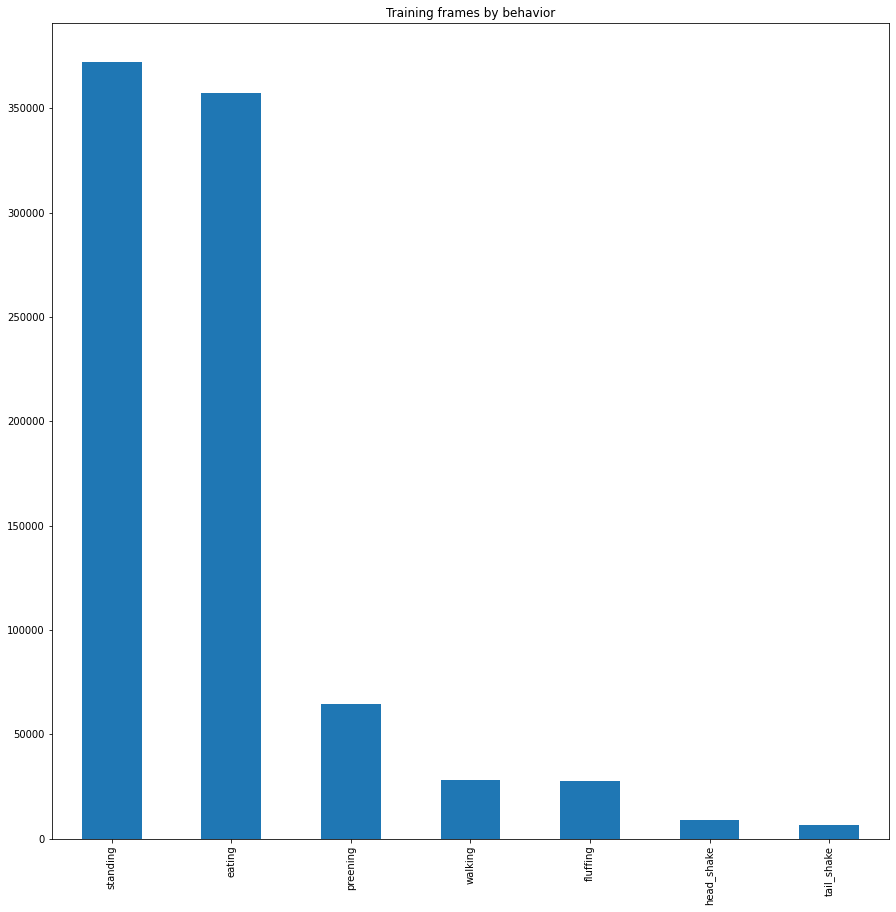

In [ ]:
# TODO: find cleaner solution that has no overlap between sessions

#df['lookback'] = df['behavior'].shift(2, fill_value="not_defined")
#df['lookup'] = df['behavior'].shift(-1, fill_value="not_defined")
#df = df[(df['behavior'] != "not_defined") | (df['lookback'] != "not_defined") | (df['lookup'] != "not_defined")]

df = df[(df['behavior'] != "not_defined")]

df.behavior.value_counts().plot(kind='bar', figsize=(15,15), title='Training frames by behavior')

In [ ]:
# validation_files = [
#     "233_monhab_gopro_cut_day1DLC_resnet50_goprovrJul24shuffle1_1030000.h5",
#     "877_100ms_gopro_cut_day3DLC_resnet50_goprovrJul24shuffle1_1030000.h5",
#     "251_100ms_gopro_cut_day4DLC_resnet50_goprovrJul24shuffle1_1030000.h5",
#     "418_500ms_gopro_cut_day1DLC_resnet50_goprovrJul24shuffle1_1030000.h5",
# ]

# df_validation = df[df['file_name'].isin(validation_files)]
# df_train_test = df[~df['file_name'].isin(validation_files)]

# valid_share = len(df_validation) / len(df_train_test)
# valid_share

0.20182541176991836

# 8 frames sliding window

In [ ]:
features = [('head', 'x'), ('head', 'y'), 
            ('tail', 'x'), ('tail', 'y'),  
            
            ('left_neck', 'x'), ('left_neck', 'y'), 
            ('right_neck', 'x'), ('right_neck', 'y'), 
            
            ('left_up_wing', 'x'), ('left_up_wing', 'y'),
            ('left_middle_wing', 'x'), ('left_middle_wing', 'y'),
            ('left_down_wing', 'x'), ('left_down_wing', 'y'),
            
            ('right_up_wing', 'x'), ('right_up_wing', 'y'),
            ('right_middle_wing', 'x'), ('right_middle_wing', 'y'),
            ('right_down_wing', 'x'), ('right_down_wing', 'y'),
]
def y_func(o): 
    return scipy.stats.mode(o, axis=1).mode.ravel()

X, y = SlidingWindow(32, get_x=features, get_y='behavior', y_func=y_func)(df)

In [ ]:
#np.savez('timeseries_8_20210518.npz', X=X, y=y)

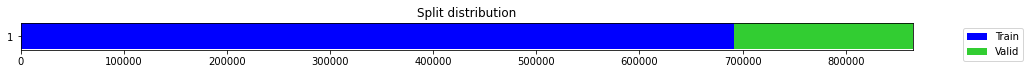

(#865516) [(TSTensor(vars:20, len:32), TensorCategory(2, dtype=torch.int32)),(TSTensor(vars:20, len:32), TensorCategory(2, dtype=torch.int32)),(TSTensor(vars:20, len:32), TensorCategory(2, dtype=torch.int32)),(TSTensor(vars:20, len:32), TensorCategory(2, dtype=torch.int32)),(TSTensor(vars:20, len:32), TensorCategory(2, dtype=torch.int32)),(TSTensor(vars:20, len:32), TensorCategory(2, dtype=torch.int32)),(TSTensor(vars:20, len:32), TensorCategory(2, dtype=torch.int32)),(TSTensor(vars:20, len:32), TensorCategory(2, dtype=torch.int32)),(TSTensor(vars:20, len:32), TensorCategory(2, dtype=torch.int32)),(TSTensor(vars:20, len:32), TensorCategory(2, dtype=torch.int32))...]

In [ ]:
splits = get_splits(y, valid_size=.2, stratify=True, random_state=23, shuffle=False)
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dsets

In [ ]:
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=[TSStandardize()], num_workers=0)
#dls.show_batch(sharey=True)

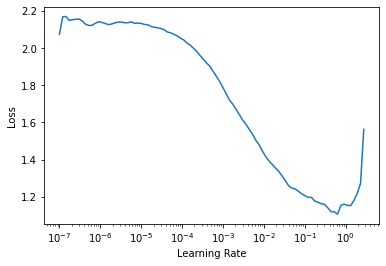

In [ ]:
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
learn.lr_find(suggestions=False)

In [ ]:
learn.fit_one_cycle(25, lr_max=1e-3)
#learn.save('stage1')

epoch,train_loss,valid_loss,accuracy,time
0,0.141322,0.376350,0.891336,07:33
1,0.103510,0.353942,0.908332,07:40
2,0.101942,0.408796,0.900909,07:41
3,0.069932,0.353627,0.915091,07:41
4,0.075423,0.449893,0.896368,07:41
5,0.054891,0.485829,0.902416,07:42
6,0.056799,0.456617,0.908684,07:39
7,0.044017,0.505678,0.907772,07:39
8,0.034903,0.475343,0.912278,07:41
9,0.029768,0.490709,0.913872,07:41


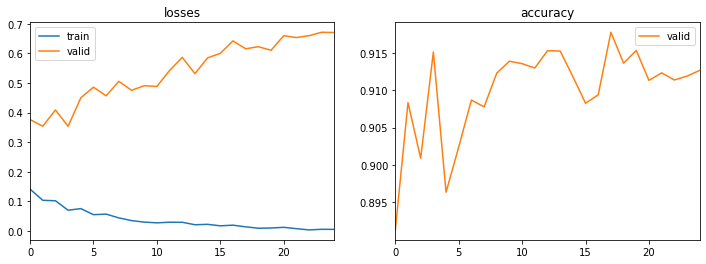

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
dls = learn.dls
valid_dl = dls.valid
b = next(iter(valid_dl))
b
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl, with_decoded=True)
valid_probas, valid_targets, valid_preds

(tensor([[2.7045e-21, 2.0991e-11, 4.1651e-12,  ..., 1.0000e+00, 5.7897e-12,
          7.7553e-14],
         [4.1074e-21, 2.8930e-11, 6.6284e-12,  ..., 1.0000e+00, 6.7613e-12,
          1.0026e-13],
         [4.9477e-21, 3.9529e-11, 8.4333e-12,  ..., 1.0000e+00, 8.5274e-12,
          1.1187e-13],
         ...,
         [1.4007e-08, 1.0848e-04, 6.1061e-01,  ..., 2.9654e-02, 1.8483e-03,
          1.0930e-03],
         [1.6491e-08, 1.1088e-04, 4.8826e-01,  ..., 2.6795e-02, 1.6526e-03,
          2.6026e-03],
         [2.3307e-08, 1.1959e-04, 2.8191e-01,  ..., 3.5410e-02, 1.8755e-03,
          7.7463e-03]]),
 TensorCategory([4, 4, 4,  ..., 2, 2, 2], dtype=torch.int32),
 tensor([4, 4, 4,  ..., 2, 2, 3]))

In [ ]:
(valid_targets == valid_preds).float().mean()

TensorCategory(0.9126)

<Figure size 432x288 with 0 Axes>

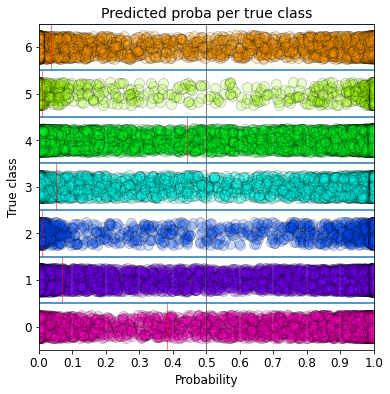

In [ ]:
fig = plt.gcf()
learn.show_probas()

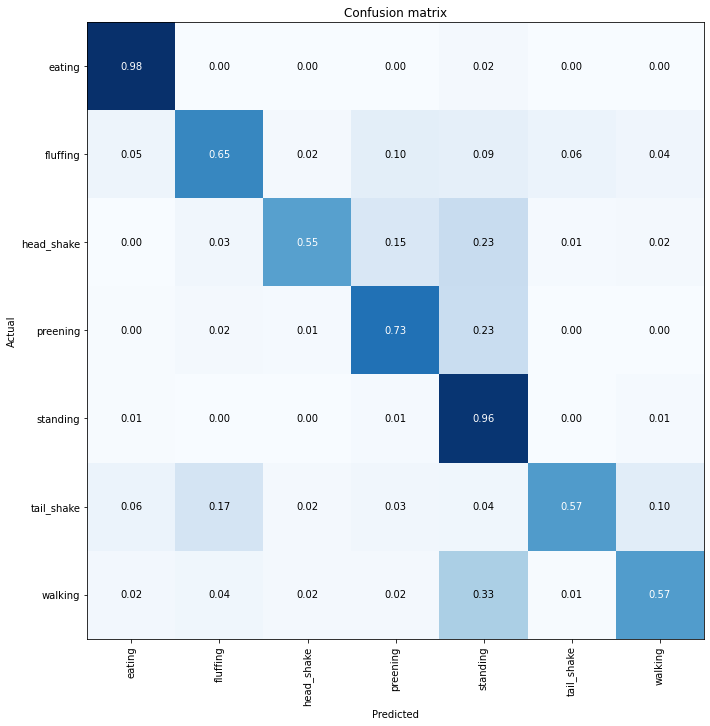

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(normalize=True, figsize=(10, 10))

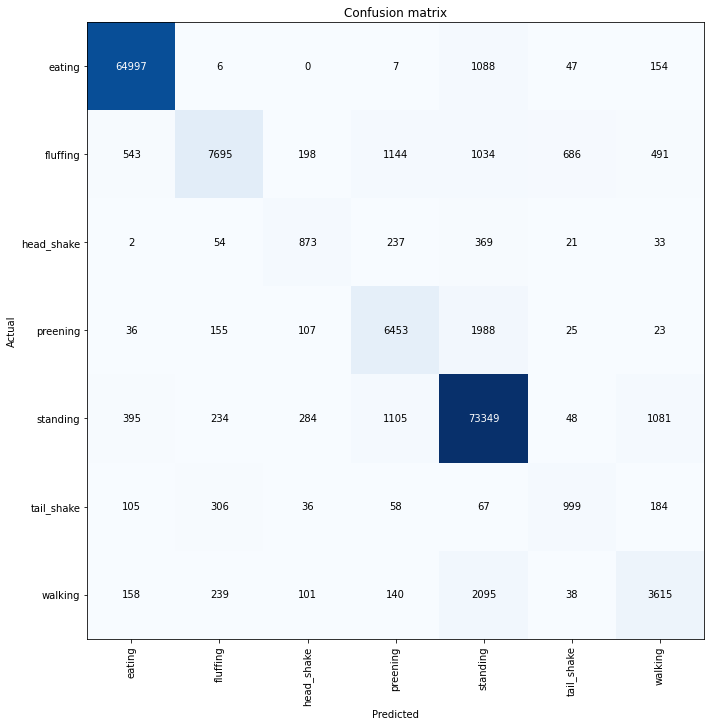

In [ ]:
interp.plot_confusion_matrix(figsize=(10, 10))

In [ ]:
learn.save('32ts_20210519')

Path('models/32ts_20210519.pth')

In [ ]:
x_test, y_test = SlidingWindow(8, get_x=features, get_y='behavior', y_func=y_func)(df_validation)

# we are using test_ds here, since copied from the examples. Holdout set should be named test set, so it is correct.

test_ds = valid_dl.dataset.add_test(x_test, y_test)
test_dl = valid_dl.new(test_ds)
next(iter(test_dl))

test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
test_probas, test_targets, test_preds

(tensor([[6.2453e-08, 1.9201e-12, 1.4149e-01,  ..., 1.1213e-05, 2.6235e-05,
          8.1545e-01],
         [1.6428e-07, 2.1788e-12, 3.2049e-01,  ..., 1.1232e-05, 4.5405e-05,
          6.3606e-01],
         [2.3515e-07, 2.7978e-12, 5.7499e-01,  ..., 5.9298e-06, 9.5307e-05,
          4.0683e-01],
         ...,
         [7.6781e-10, 1.2530e-11, 2.9645e-13,  ..., 5.2869e-13, 7.0229e-09,
          3.7836e-06],
         [5.9647e-09, 8.6433e-11, 9.8797e-13,  ..., 1.1179e-12, 6.7159e-08,
          1.6896e-05],
         [2.1103e-08, 2.8778e-10, 6.3139e-12,  ..., 2.3375e-12, 3.6276e-07,
          9.2007e-05]]),
 TensorCategory([2, 2, 2,  ..., 8, 8, 8], dtype=torch.int32),
 tensor([11, 11,  2,  ...,  8,  8,  8]))

In [ ]:
(test_targets == test_preds).float().mean()

TensorCategory(0.8101)

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

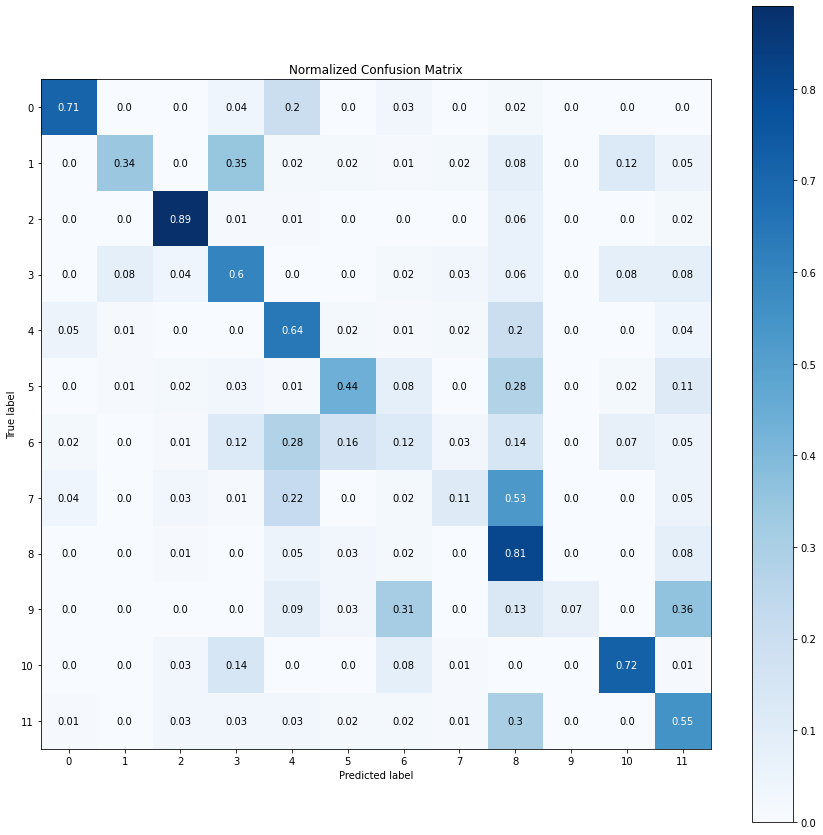

In [ ]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(test_targets, test_preds, figsize=(15, 15), normalize=True)  

<Figure size 432x288 with 0 Axes>

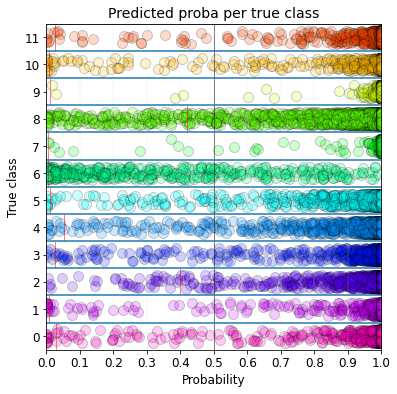

In [ ]:
fig = plt.gcf()
learn.show_probas()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn, ds_idx=2)
interp.plot_confusion_matrix(normalize=True, figsize=(10, 10))

IndexError: list index out of range

In [ ]:
interp.plot_confusion_matrix(figsize=(10, 10))

In [ ]:
interp.most_confused(min_val=3)

In [ ]:
test_targets

TensorCategory([2, 2, 2,  ..., 8, 8, 8], dtype=torch.int32)

In [ ]:
print(roc_auc_score(test_targets, test_probas, multi_class='ovo', average='macro'))

0.8640056284478392


In [ ]:
print(classification_report(test_targets, test_preds))

              precision    recall  f1-score   support

           0       0.66      0.71      0.68      2168
           1       0.31      0.34      0.32       355
           2       0.99      0.89      0.94     69117
           3       0.47      0.60      0.53      2263
           4       0.39      0.64      0.49      4770
           5       0.12      0.44      0.19       537
           6       0.01      0.12      0.02       126
           7       0.19      0.11      0.14      1338
           8       0.83      0.81      0.82     54374
           9       0.08      0.07      0.08       401
          10       0.48      0.72      0.58       483
          11       0.48      0.55      0.51      9828

    accuracy                           0.81    145760
   macro avg       0.42      0.50      0.44    145760
weighted avg       0.85      0.81      0.82    145760



In [ ]:
learn.save('16ts')

Path('models/16ts.pth')

# 60 frames sliding window

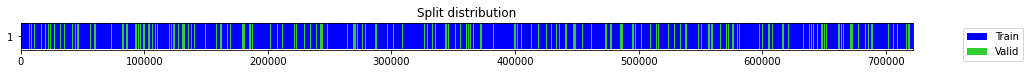

In [ ]:
features = [('head', 'x'), ('head', 'y'), 
            ('tail', 'x'), ('tail', 'y'),  
            
            ('left_neck', 'x'), ('left_neck', 'y'), 
            ('right_neck', 'x'), ('right_neck', 'y'), 
            
            ('left_up_wing', 'x'), ('left_up_wing', 'y'),
            ('left_middle_wing', 'x'), ('left_middle_wing', 'y'),
            ('left_down_wing', 'x'), ('left_down_wing', 'y'),
            
            ('right_up_wing', 'x'), ('right_up_wing', 'y'),
            ('right_middle_wing', 'x'), ('right_middle_wing', 'y'),
            ('right_down_wing', 'x'), ('right_down_wing', 'y'),
]
def y_func(o): 
    return scipy.stats.mode(o, axis=1).mode.ravel()

X, y = SlidingWindow(60, get_x=features, get_y='behavior', y_func=y_func)(df_train_test)
splits = get_splits(y, valid_size=.2, stratify=True, random_state=23, shuffle=True) # try with False later
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=[TSStandardize()], num_workers=0)


epoch,train_loss,valid_loss,accuracy,time
0,0.163721,0.148181,0.954409,06:29
1,0.118410,0.094879,0.971704,06:25
2,0.106706,0.088401,0.972812,06:29
3,0.084487,0.084043,0.973089,06:26
4,0.079638,0.090442,0.971725,06:26
5,0.071976,0.063110,0.981057,06:25
6,0.055893,0.057679,0.982567,06:25
7,0.051316,0.040843,0.987116,06:25
8,0.041792,0.037703,0.988618,06:24
9,0.038277,0.037543,0.988611,06:22


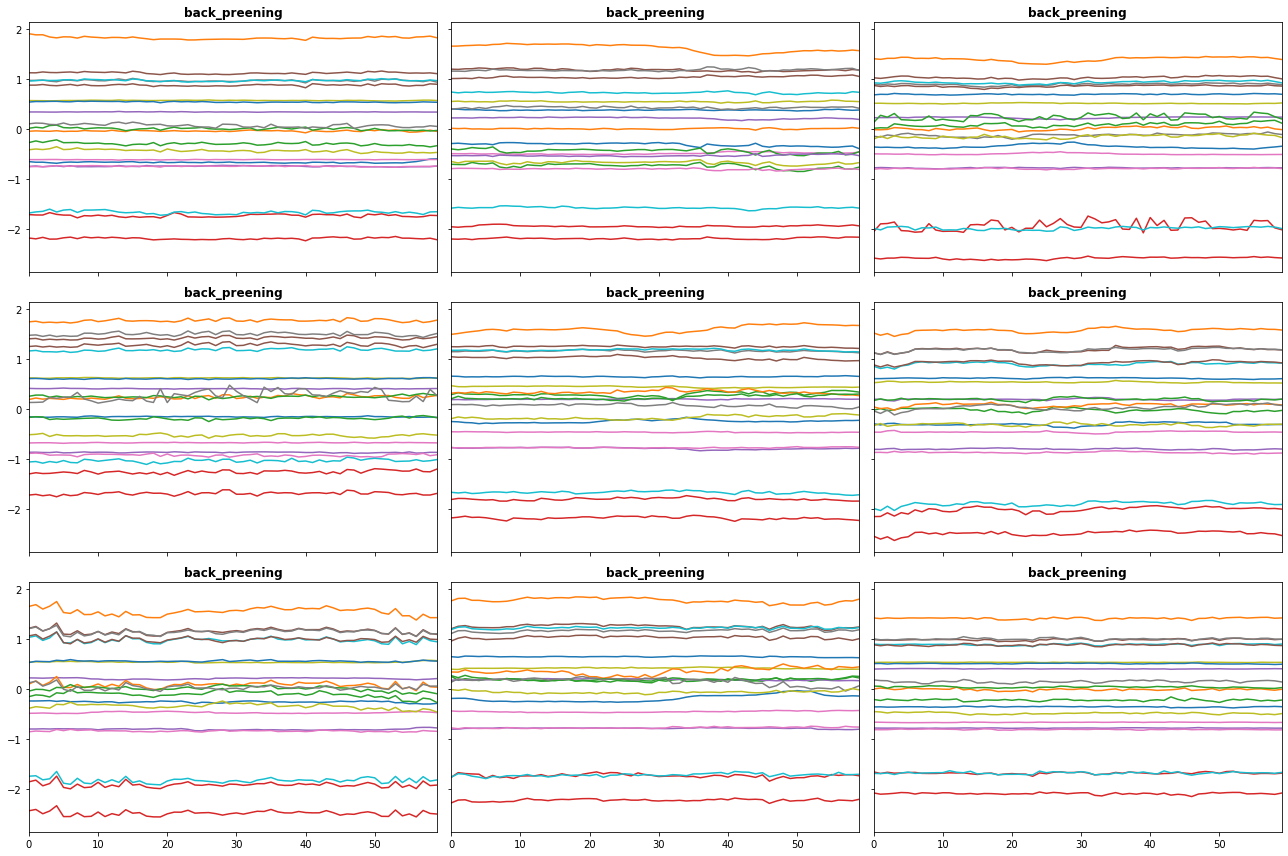

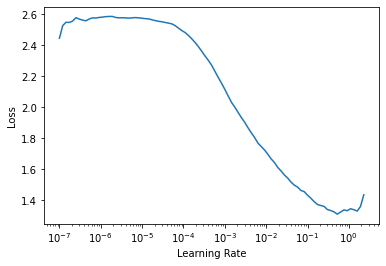

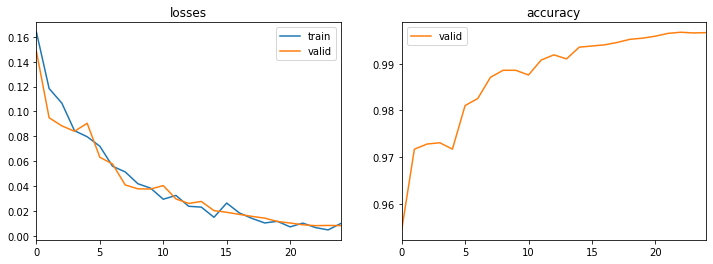

TensorCategory(0.9967)


<Figure size 432x288 with 0 Axes>

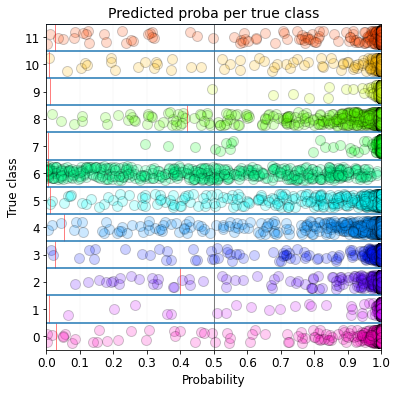

[('not_defined', 'front_preening', 78),
 ('not_defined', 'head_shake', 60),
 ('front_preening', 'not_defined', 32),
 ('head_shake', 'not_defined', 29),
 ('not_defined', 'back_preening', 24),
 ('not_defined', 'tail_shake', 24),
 ('walking', 'standing', 19),
 ('not_defined', 'feather_clapping', 18),
 ('not_defined', 'scratch_with_feet', 17),
 ('feather_clapping', 'not_defined', 16),
 ('eating', 'standing', 15),
 ('standing', 'eating', 15),
 ('back_preening', 'not_defined', 14),
 ('head_shake', 'standing', 12),
 ('tail_shake', 'not_defined', 10),
 ('standing', 'walking', 9),
 ('not_defined', 'standing', 8),
 ('standing', 'head_shake', 7),
 ('front_preening', 'standing', 6),
 ('not_defined', 'body_pump', 6),
 ('not_defined', 'eating', 6),
 ('back_preening', 'head_shake', 4),
 ('body_pump', 'not_defined', 3),
 ('feather_clapping', 'head_shake', 3),
 ('front_preening', 'head_shake', 3),
 ('tail_shake', 'feather_clapping', 3)]

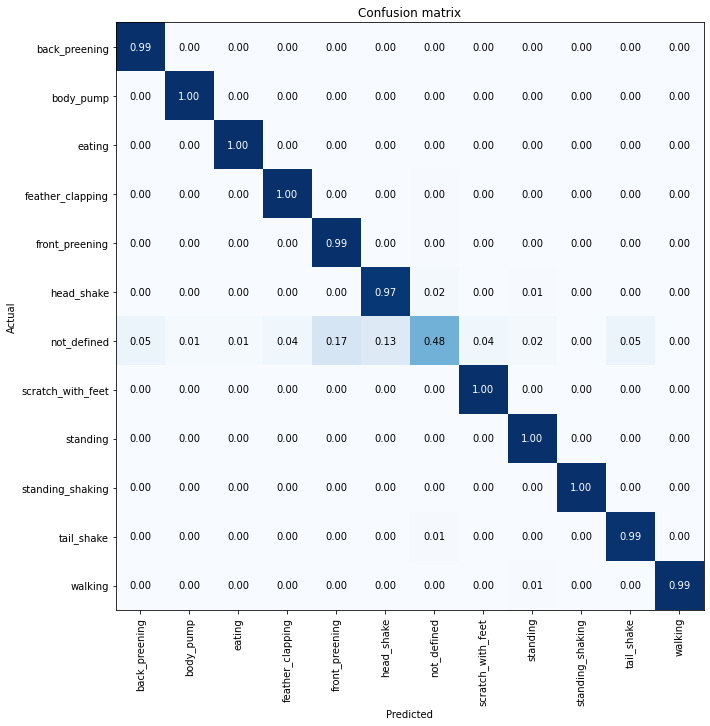

In [ ]:
dls.show_batch(sharey=True)
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
learn.lr_find(suggestions=False)
learn.fit_one_cycle(25, lr_max=1e-3)
learn.recorder.plot_metrics()
dls = learn.dls
valid_dl = dls.valid
b = next(iter(valid_dl))
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl, with_decoded=True)
valid_probas, valid_targets, valid_preds
print((valid_targets == valid_preds).float().mean())
fig = plt.gcf()
learn.show_probas()
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(normalize=True, figsize=(10, 10))
interp.most_confused(min_val=3)

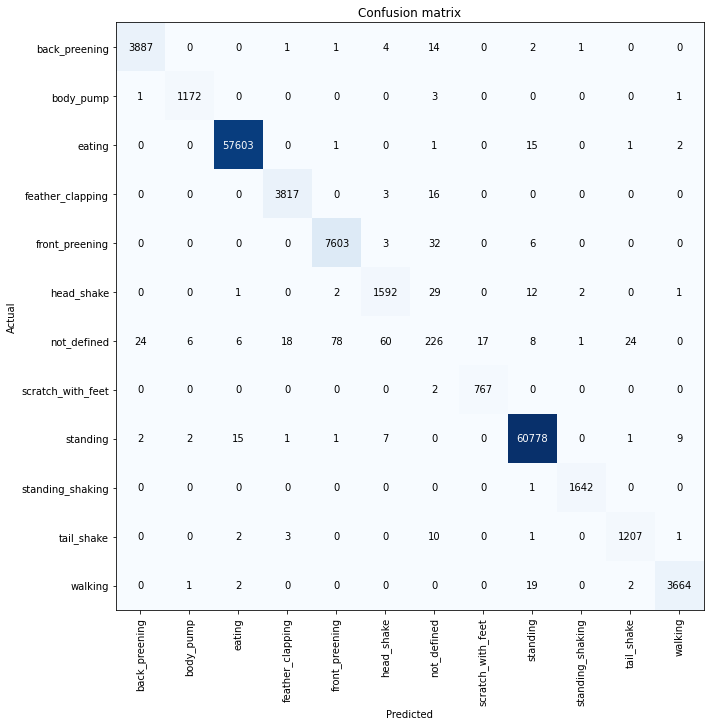

In [ ]:
interp.plot_confusion_matrix(figsize=(10, 10))

In [ ]:
x_test, y_test = SlidingWindow(60, get_x=features, get_y='behavior', y_func=y_func)(df_validation)

# we are using test_ds here, since copied from the examples. Holdout set should be named test set, so it is correct.

test_ds = valid_dl.dataset.add_test(x_test, y_test)
test_dl = valid_dl.new(test_ds)
next(iter(test_dl))

test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
test_probas, test_targets, test_preds

(tensor([[5.2640e-11, 1.2237e-12, 9.9932e-01,  ..., 7.2291e-09, 9.8525e-06,
          4.1474e-07],
         [2.7871e-11, 1.0321e-12, 9.9961e-01,  ..., 6.8914e-09, 5.3563e-06,
          4.7198e-07],
         [1.7389e-11, 1.0558e-12, 9.9973e-01,  ..., 7.0984e-09, 3.9605e-06,
          5.6304e-07],
         ...,
         [8.4235e-11, 9.8802e-12, 2.2021e-14,  ..., 4.0477e-09, 3.6215e-10,
          5.2432e-07],
         [1.4966e-10, 2.0850e-11, 1.9616e-14,  ..., 6.4659e-09, 6.5206e-10,
          1.0047e-06],
         [2.1984e-10, 3.8754e-11, 1.8751e-14,  ..., 9.2968e-09, 1.0596e-09,
          1.3801e-06]]),
 TensorCategory([2, 2, 2,  ..., 8, 8, 8], dtype=torch.int32),
 tensor([2, 2, 2,  ..., 8, 8, 8]))

In [ ]:
(test_targets == test_preds).float().mean()

TensorCategory(0.8734)

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

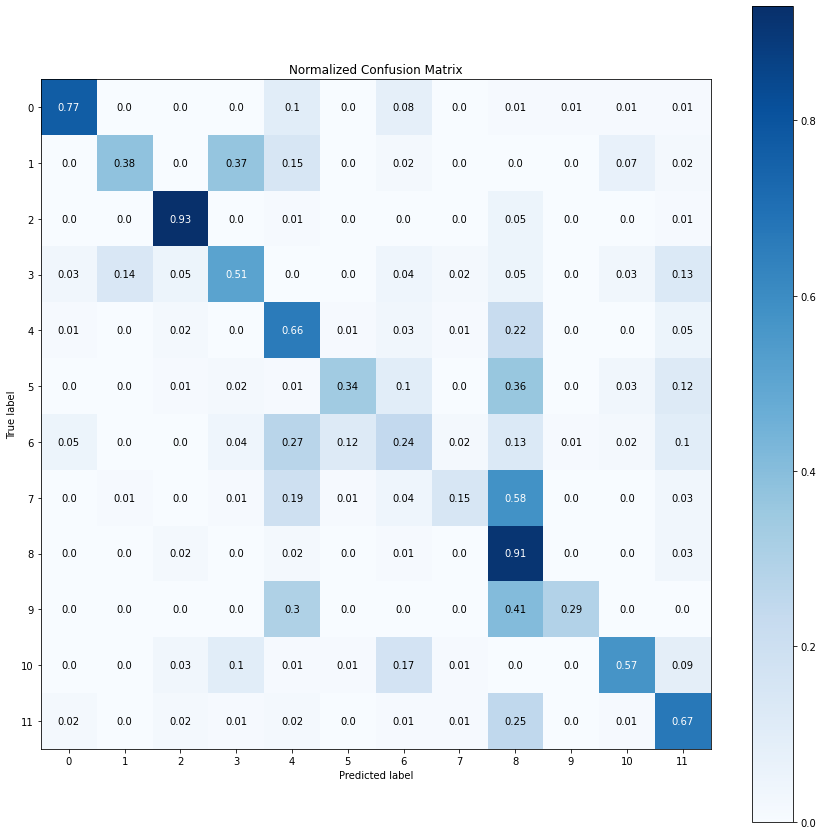

In [ ]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(test_targets, test_preds, figsize=(15, 15), normalize=True)  

In [ ]:
learn.save('60ts')

Path('models/60ts.pth')

# 30 frames sliding window

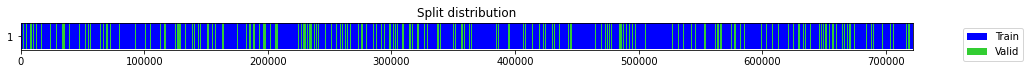

In [ ]:
features = [('head', 'x'), ('head', 'y'), 
            ('tail', 'x'), ('tail', 'y'),  
            
            ('left_neck', 'x'), ('left_neck', 'y'), 
            ('right_neck', 'x'), ('right_neck', 'y'), 
            
            ('left_up_wing', 'x'), ('left_up_wing', 'y'),
            ('left_middle_wing', 'x'), ('left_middle_wing', 'y'),
            ('left_down_wing', 'x'), ('left_down_wing', 'y'),
            
            ('right_up_wing', 'x'), ('right_up_wing', 'y'),
            ('right_middle_wing', 'x'), ('right_middle_wing', 'y'),
            ('right_down_wing', 'x'), ('right_down_wing', 'y'),
]
def y_func(o): 
    return scipy.stats.mode(o, axis=1).mode.ravel()

X, y = SlidingWindow(30, get_x=features, get_y='behavior', y_func=y_func)(df_train_test)
splits = get_splits(y, valid_size=.2, stratify=True, random_state=23, shuffle=True) # try with False later
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=[TSStandardize()], num_workers=0)


epoch,train_loss,valid_loss,accuracy,time
0,0.188438,0.166193,0.948236,06:15
1,0.149081,0.124707,0.961161,06:17
2,0.130570,0.110205,0.964907,06:19
3,0.110170,0.085821,0.973457,06:18
4,0.086122,0.084256,0.973921,06:19
5,0.080324,0.072209,0.977424,05:54
6,0.071068,0.054673,0.983440,05:42
7,0.065451,0.060792,0.981370,06:07
8,0.051585,0.047084,0.985406,06:19
9,0.047850,0.039602,0.988009,06:21


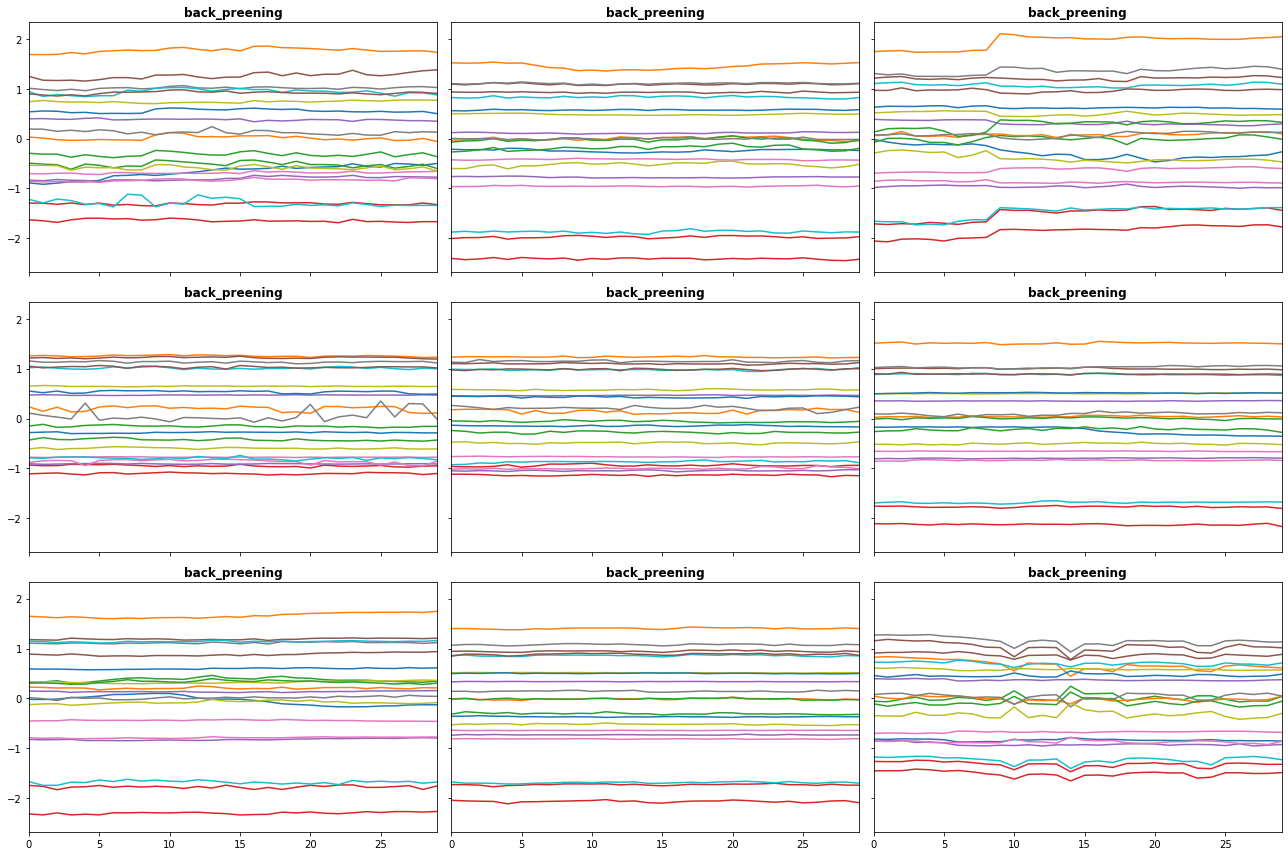

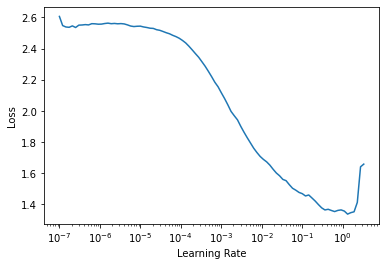

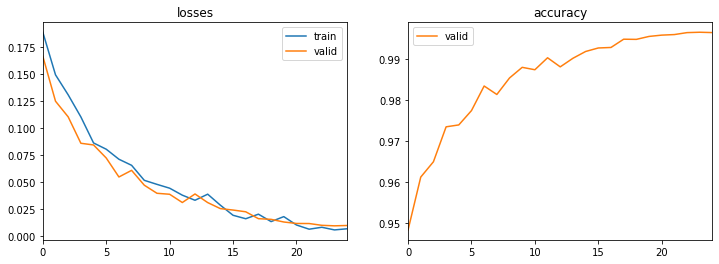

TensorCategory(0.9965)


<Figure size 432x288 with 0 Axes>

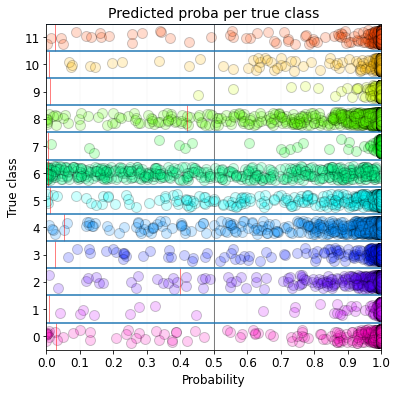

[('not_defined', 'front_preening', 73),
 ('not_defined', 'head_shake', 48),
 ('not_defined', 'tail_shake', 34),
 ('not_defined', 'feather_clapping', 31),
 ('head_shake', 'not_defined', 29),
 ('standing', 'eating', 29),
 ('front_preening', 'not_defined', 28),
 ('feather_clapping', 'not_defined', 19),
 ('back_preening', 'not_defined', 17),
 ('eating', 'standing', 17),
 ('not_defined', 'back_preening', 14),
 ('not_defined', 'scratch_with_feet', 14),
 ('standing', 'walking', 14),
 ('walking', 'standing', 13),
 ('head_shake', 'standing', 11),
 ('front_preening', 'standing', 10),
 ('standing', 'front_preening', 8),
 ('tail_shake', 'not_defined', 8),
 ('front_preening', 'head_shake', 7),
 ('not_defined', 'body_pump', 7),
 ('not_defined', 'standing', 7),
 ('body_pump', 'not_defined', 6),
 ('back_preening', 'feather_clapping', 5),
 ('back_preening', 'head_shake', 5),
 ('scratch_with_feet', 'not_defined', 5),
 ('standing', 'head_shake', 5),
 ('standing', 'standing_shaking', 5),
 ('walking', 'eat

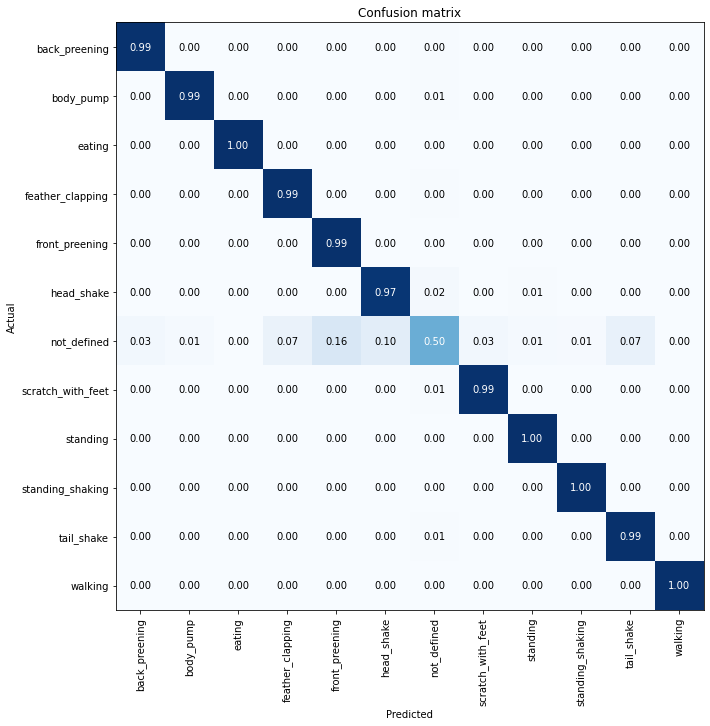

In [ ]:
dls.show_batch(sharey=True)
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
learn.lr_find(suggestions=False)
learn.fit_one_cycle(25, lr_max=1e-3)
learn.recorder.plot_metrics()
dls = learn.dls
valid_dl = dls.valid
b = next(iter(valid_dl))
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl, with_decoded=True)
valid_probas, valid_targets, valid_preds
print((valid_targets == valid_preds).float().mean())
fig = plt.gcf()
learn.show_probas()
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(normalize=True, figsize=(10, 10))
interp.most_confused(min_val=3)

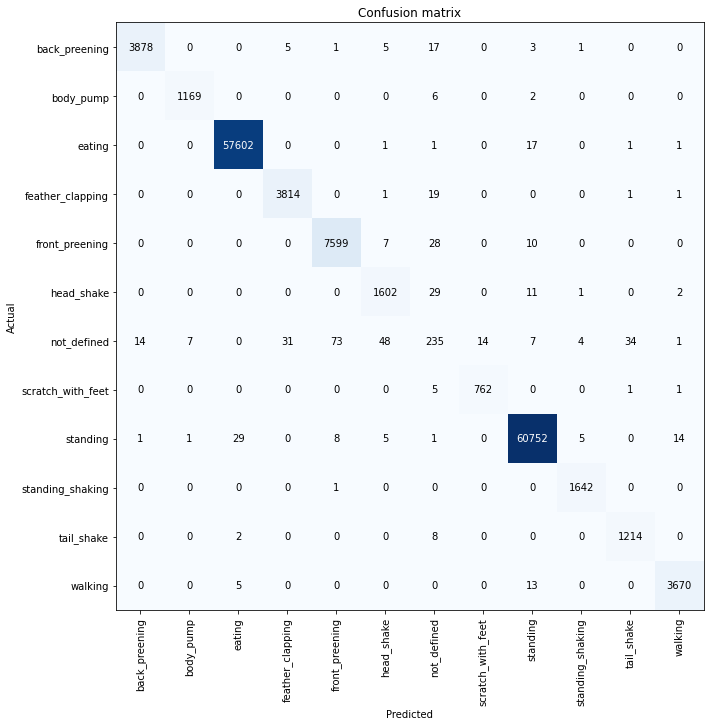

In [ ]:
interp.plot_confusion_matrix(figsize=(10, 10))

In [ ]:
x_test, y_test = SlidingWindow(30, get_x=features, get_y='behavior', y_func=y_func)(df_validation)

# we are using test_ds here, since copied from the examples. Holdout set should be named test set, so it is correct.

test_ds = valid_dl.dataset.add_test(x_test, y_test)
test_dl = valid_dl.new(test_ds)
next(iter(test_dl))

test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
test_probas, test_targets, test_preds

(tensor([[8.3673e-12, 4.0081e-11, 9.8700e-01,  ..., 1.0976e-08, 2.3890e-08,
          1.0571e-05],
         [3.8042e-12, 2.1556e-11, 9.9251e-01,  ..., 6.4550e-09, 1.4982e-08,
          7.8459e-06],
         [2.2298e-12, 1.4471e-11, 9.9424e-01,  ..., 4.9838e-09, 9.7821e-09,
          6.2169e-06],
         ...,
         [4.1532e-12, 2.7724e-14, 1.6213e-16,  ..., 6.5629e-15, 4.5119e-13,
          1.7123e-10],
         [3.3165e-12, 4.2239e-14, 1.1286e-16,  ..., 9.4285e-15, 5.4461e-13,
          1.6473e-10],
         [3.3066e-12, 6.2234e-14, 8.3725e-17,  ..., 1.5137e-14, 6.1548e-13,
          1.4842e-10]]),
 TensorCategory([2, 2, 2,  ..., 8, 8, 8], dtype=torch.int32),
 tensor([2, 2, 2,  ..., 8, 8, 8]))

In [ ]:
(test_targets == test_preds).float().mean()

TensorCategory(0.8652)

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

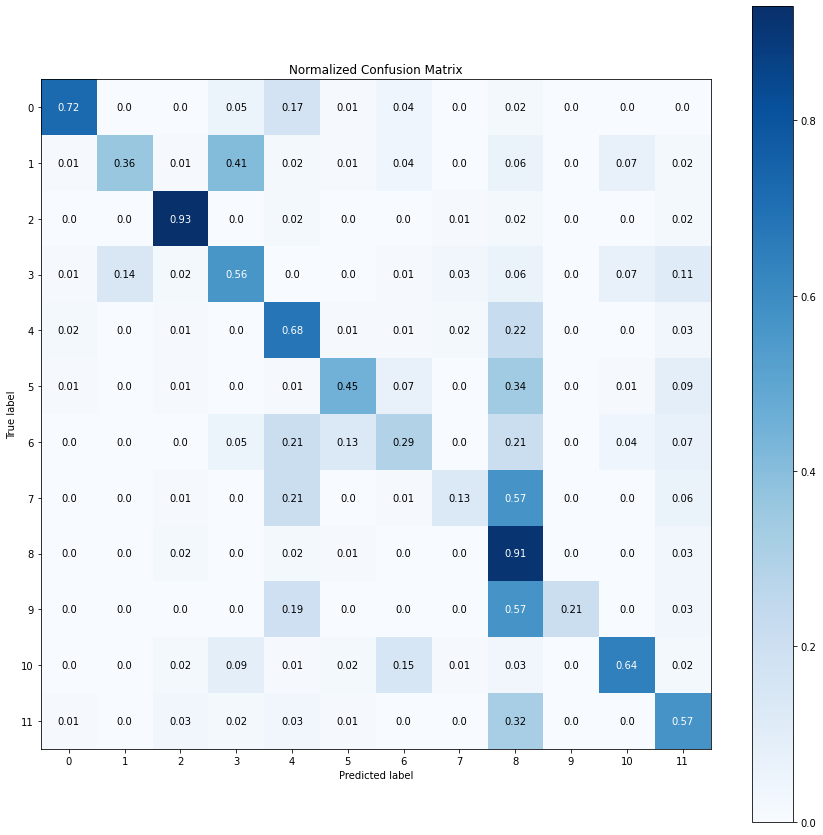

In [ ]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(test_targets, test_preds, figsize=(15, 15), normalize=True)  

In [ ]:
learn.save('30ts')

Path('models/30ts.pth')

# Shuffled Data
When splitting timeseries data, one should normally not take random samples for splitting into train and test set, because the data has a natural ordering and is dependent/related. However, we still did it to get a feel for the performance (which in this case could mean overfitting the data).

On the other hand, for the semantic correct splitting, we should take care to split the sets by hand, to have similar distribution of behaviours.

In [ ]:
ts = np.load('timeseries_8_20212608.npz', allow_pickle=True) # pickle will work without mutating the data?
X = ts['X']
y = ts['y']

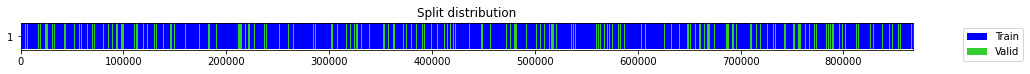

epoch,train_loss,valid_loss,accuracy,time
0,0.234555,0.223542,0.929499,03:50
1,0.179232,0.176867,0.944574,03:53
2,0.168451,0.173522,0.944228,03:40
3,0.147787,0.155852,0.949931,03:37
4,0.133456,0.139087,0.955784,03:34
5,0.119727,0.132263,0.957990,03:34
6,0.096737,0.108489,0.965841,03:34
7,0.096441,0.103052,0.967229,03:35
8,0.086616,0.087117,0.972990,03:42
9,0.088391,0.086535,0.972229,03:50


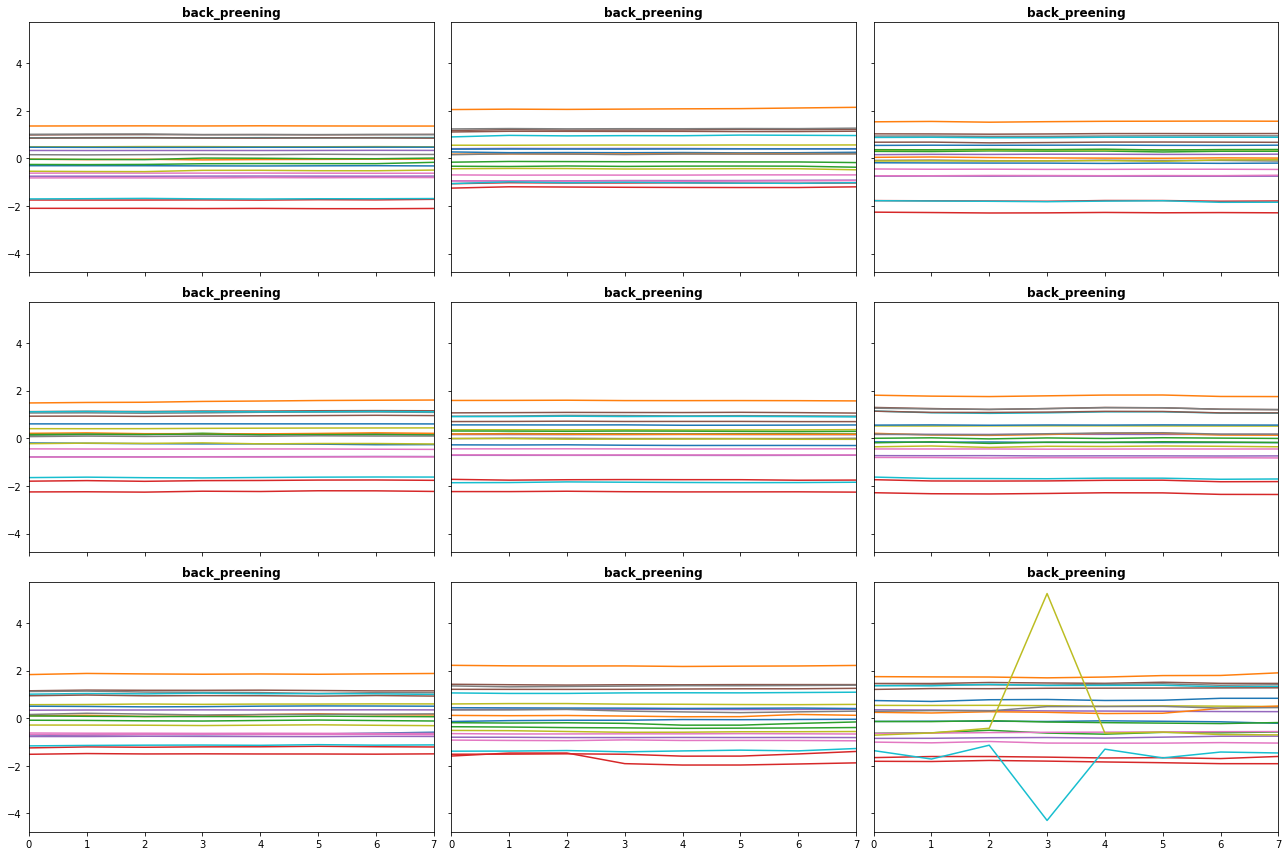

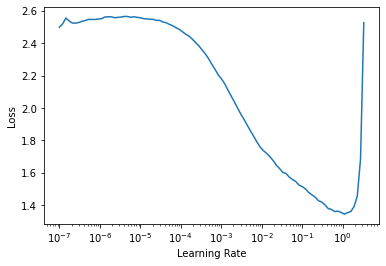

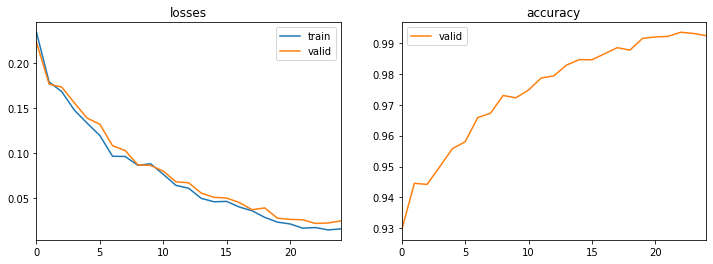

TensorCategory(0.9923)


<Figure size 432x288 with 0 Axes>

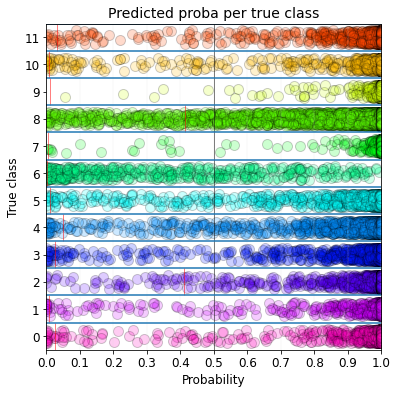

[('standing', 'eating', 158),
 ('standing', 'walking', 114),
 ('not_defined', 'front_preening', 80),
 ('not_defined', 'head_shake', 62),
 ('head_shake', 'standing', 58),
 ('walking', 'standing', 58),
 ('eating', 'standing', 50),
 ('front_preening', 'standing', 46),
 ('not_defined', 'tail_shake', 44),
 ('head_shake', 'not_defined', 41),
 ('front_preening', 'not_defined', 36),
 ('not_defined', 'back_preening', 35),
 ('not_defined', 'feather_clapping', 29),
 ('body_pump', 'tail_shake', 23),
 ('tail_shake', 'feather_clapping', 23),
 ('standing', 'front_preening', 19),
 ('feather_clapping', 'body_pump', 17),
 ('not_defined', 'standing', 17),
 ('feather_clapping', 'not_defined', 16),
 ('feather_clapping', 'tail_shake', 16),
 ('feather_clapping', 'walking', 15),
 ('back_preening', 'front_preening', 13),
 ('front_preening', 'head_shake', 13),
 ('tail_shake', 'not_defined', 13),
 ('tail_shake', 'walking', 13),
 ('not_defined', 'scratch_with_feet', 12),
 ('standing', 'head_shake', 12),
 ('back_p

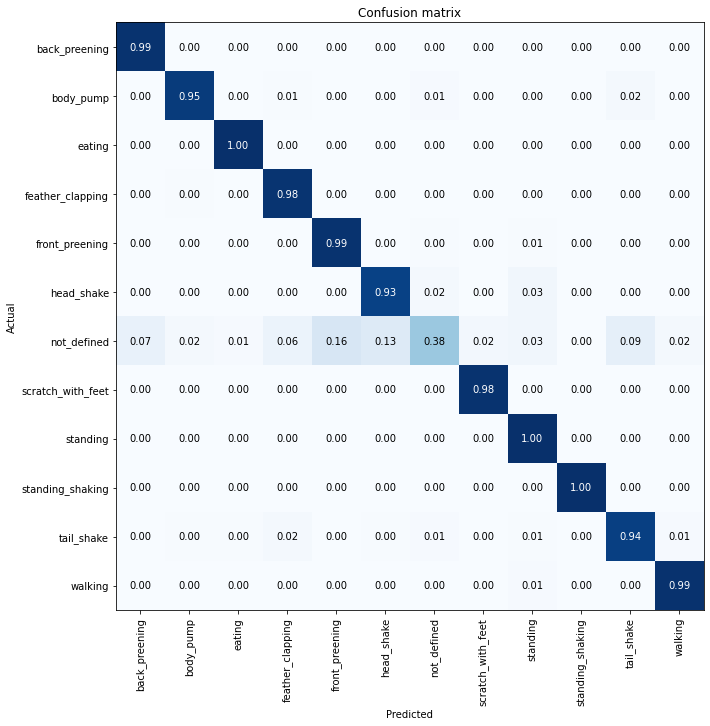

In [ ]:
splits = get_splits(y, valid_size=.2, stratify=True, random_state=23, shuffle=True) # try with False later
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=[TSStandardize()], num_workers=0)
dls.show_batch(sharey=True)
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
learn.lr_find(suggestions=False)
learn.fit_one_cycle(25, lr_max=1e-3)
learn.recorder.plot_metrics()
dls = learn.dls
valid_dl = dls.valid
b = next(iter(valid_dl))
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl, with_decoded=True)
valid_probas, valid_targets, valid_preds
print((valid_targets == valid_preds).float().mean())
fig = plt.gcf()
learn.show_probas()
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(normalize=True, figsize=(10, 10))
interp.most_confused(min_val=3)